# Sklearn Pipelines for the Modern ML Engineer: 9 Techniques You Can't Ignore
## There are so many ways you can build them...

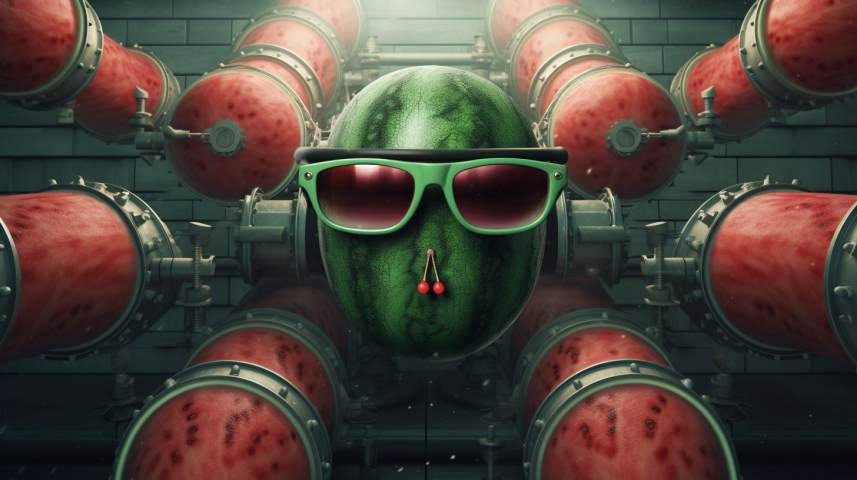

### Motivation

Today, this is what I am selling:

```python
awesome_pipeline.fit(X, y)
```

`awesome_pipeline` may look just like another variable but here is what it does to poor `X` and `y` under the hood:

1. Automatically isolates numerical and categorical features of `X`.
2. Imputes missing values in numeric features and scales them all.
3. Log-transforms skewed features while normalizing the rest.
4. Imputes missing values in categorical features and one-hot encodes them.
5. Normalizes the target array `y` for good measure.

Apart from collapsing almost 100 lines worth of unreadable code into a single line, `awesome_pipeline` can now be inserted into cross-validators or hyperparameter tuners and it will guard your code from data leakage, make everything reproducible, modular and headache-free.

Let's see how to build the thing.

### 0. Estimators vs transformers

First, let's get the terminology out of the way. 

A transformer in Sklearn is any class or a function that accepts features of a dataset, applies transformations and returns it. It has a `fit_transform` and `transform` methods.

An example is a `QuantileTransformer` which takes numeric input(s) and makes them normally distributed. It is especially useful for features with [outliers](https://towardsdatascience.com/how-to-perform-outlier-detection-in-python-in-easy-steps-for-machine-learning-1-8f9a3e6c88b5).

Transformers inherit from the `TransformerMixin` base class.

In [12]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import QuantileTransformer

isinstance(QuantileTransformer(), TransformerMixin)

True

On the other hand, an estimator is any class that usually generates predictions on a dataset. They tend to end with words like `Regressor` or `Classifier`.

They inherit from the `BaseEstimator` class.

In [13]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDRegressor

isinstance(SGDRegressor(), BaseEstimator)

True

### 1. Vanilla pipeline

A vanilla pipeline in Sklearn always consists of one or more transformers of the same type and one final estimator. It chains the transformers to perform a series of operations on the feature array (`X`) so that you won't have to call `fit_transform` for each transformer and feed the final output to the estimator. All in a single line of code.

```python
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline


# Define the numeric pipeline
numeric_pipeline = make_pipeline(
    StandardScaler(), SimpleImputer(), LinearRegression()
)

numeric_pipeline.fit(only_numeric_X, y)
```

To build a vanilla pipeline, you can use the `make_pipeline` function and pass the transformers and the estimator. The order matters.

The above is an example of a __numeric pipeline__ which you can only fit to a dataset with numeric features. The other one is a categorical pipeline, suitable for datasets with only categorical features:

```python
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Define the categorical pipeline
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    StandardScaler(),
    LogisticRegression(),
)
```

Each item passed into `make_pipeline` is called a step in the pipeline, as you can see from the output below:

In [22]:
numeric_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

`make_pipeline` function automatically assigns names for each step but these names can be quite long and explicit. 

To give custom step names, you have to use the `Pipeline` class directly:

In [ ]:
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline(
    steps=[
        ("scale", StandardScaler()),
        ("impute", SimpleImputer()),
        ("lr", LinearRegression()),
    ]
)

The `steps` argument accepts a list of tuples with two items:

1. Step name as a string.
2. The transformer or the estimator for the step.

We will see the importance of properly naming steps after a few sections.

### 2. A milkshake of transformers

You will rarely use vanilla transformers on their own because real-world datasets often contain a mixture of numeric and categorical features. 

This means you need a way to mix different categories of transformers into one object while also specifying which transformer applies to which columns in the dataset `X`.

This process is beautifully implemented in the `ColumnTransformer` class. 

In step 0, you have to define the numeric and categorical features separately:

In [23]:
nums = ["numeric_1", "numeric_2", "numeric_3"]
cats = ["categorical_1", "categorical_2", "categorical_3"]

In step 1, define two transformer-only pipelines for both numeric and categorical features:

In [ ]:
numeric_pipe = make_pipeline(SimpleImputer(), QuantileTransformer())
categorical_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OrdinalEncoder()
)

Then, you can create an instance of a `ColumnTransformer` class:

In [24]:
from sklearn.compose import ColumnTransformer

transformers = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, nums),
        ("categorical", categorical_pipeline, cats),
    ]
)

Its `transformers` argument accepts a list of three-item tuples:

1. The name of the step.
2. The transformer or a pipeline of transformers.
3. The name of the columns the transformers should be applied to.

When you use this `transformers` object, it will apply two kinds of operations on both numeric and categorical features in isolation and join the result to return a single matrix again.

So, a `ColumnTransformer` is a more complex pipeline that lacks a final estimator. Let's add one to it.

### 3. A milkshake with a watermelon on top

Right now, our semi-pipeline only _transforms_ the dataset `X`:

```python
X_transformed = transformers.fit_transform(X)
```

The only thing missing from it is an estimator. This is easily fixable:

In [25]:
full_pipeline_reg = make_pipeline(transformers, LinearRegression())

# You can also use `Pipeline` class for named steps
full_pipeline_clf = Pipeline(
    steps=[
        ("preprocess", transformers),
        ("clf", LogisticRegression()),
    ]
)

Depending on the machine learning task, you have to chain either a Regressor or a Classifier estimator and the final result will have a `fit` and `predict` method.

In [ ]:
# y is a classification label
full_pipeline_clf.fit(X, y)

# y is a numeric label
full_pipeline_reg.fit(X, y)

### 4. Choosing columns with style

While defining the `ColumnTransformer`, we specified the numeric and categorical features one-by-one manually. Like a caveman. 

But there is a cool way of doing it in Sklearn. 

In [29]:
import numpy as np
from sklearn.compose import make_column_selector

numeric_cols = make_column_selector(dtype_include=np.number)
categoricals = make_column_selector(dtype_exclude=np.number)

`make_column_selector` is a handy function to automatically isolate columns from matrices in a variety of ways. Above is an example of filtering based on the data type. You can also use the the `pattern` parameter to specify a RegEx pattern to filter the column names. 

Here is an example:

In [ ]:
pattern = "^(word1|word2)"
filtered_columns = make_column_selector(pattern)

It will capture columns that start either with `word1` or `word2`. 

The function is only useful when building `ColumnTransformer` objects. It eliminates the need to write down each and every column name in a list, a task which can become almost impossible when there are dozens of columns in the data.

In [36]:
from sklearn.compose import make_column_transformer

# Automatically capture cols based on dtype
nums = make_column_selector(dtype_include=np.number)
cats = make_column_selector(dtype_exclude=np.number)

# Build the pipelines
numeric_pipe = make_pipeline(...)
categorical_pipe = make_pipeline(...)

transformers = make_column_transformer(
    (nums, numeric_pipe), (cats, categorical_pipe)
)

`make_column_transformer` is a shorthand function like `pipeline` to build `ColumnTransformer` objects without specifying step names. Combining it with `make_column_selector` will make your code much shorter.

### 5. Visual pipelines

When you print a complex pipeline like `full_pipeline_clf`, you will get an unreadable mess in your Jupyter notebook.

To fix this, you can set `display` to `diagram` inside `set_config` function:

In [38]:
from sklearn import set_config

set_config(display="diagram")

Now, when you return the pipeline, an HTML diagram is activated:

In [39]:
full_pipeline_clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('linearregression',
                                                                   LinearRegression())]),
                                                  ['numeric_1', 'numeric_2',
                                                   'numeric_3']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('logisticregression',
                                                                   LogisticRegression())]),
                                                  ['categorical_1',
                                                   'categorical_2',
                                                   'categorical_3'])])),
                ('logisticregression', LogisticRegression())])

This is useful for diagnostic and debugging purposes.

### 5. Inside stuff

### 6. Custom transformers

### 7. Target transformations

### Conclusion